<a href="https://colab.research.google.com/github/mjmousavi97/Deep-Learning-Tehran-uni/blob/main/HomeWorks/05%20HW/src/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import zipfile
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import numpy as np

In [2]:
uploaded = files.upload()

Saving Annotations.zip to Annotations (1).zip
Saving Images.zip to Images (1).zip


In [3]:
with zipfile.ZipFile('/content/Images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [4]:
with zipfile.ZipFile('/content/Annotations.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [5]:
file_name = 'airplane_440'
img = cv2.imread(os.path.join('/content/Images/Images/', file_name + '.jpg'))

In [6]:
df = pd.read_csv(os.path.join('/content/Airplanes_Annotations/',  file_name + '.csv'))

In [7]:
df

,1
0,115 53 219 156


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

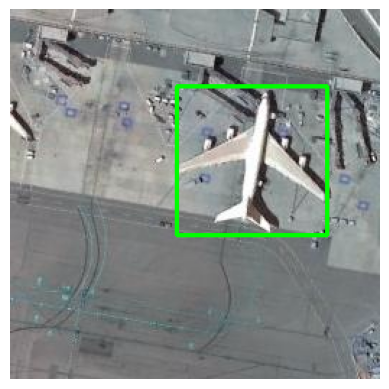

In [8]:
for i, row in df.iterrows():
    _, row = next(row.items())

    x1 = int(row.split(' ')[0])
    y1 = int(row.split(' ')[1])
    x2 = int(row.split(' ')[2])
    y2 = int(row.split(' ')[3])

    cv2.rectangle(img=img, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=2)

plt.figure()
plt.imshow(img)
plt.axis('off')


# **Intersection of Union**

In [9]:
def iou_calc(box1: dict, box2: dict) -> float:
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Each box should be a dictionary with keys:
        'x1', 'y1' -> coordinates of the top-left corner
        'x2', 'y2' -> coordinates of the bottom-right corner

    Returns a float between 0.0 and 1.0 representing how much the boxes overlap.
    If they don't overlap at all, returns 0.0.

    Example:
        box_a = {'x1': 0, 'y1': 0, 'x2': 2, 'y2': 2}
        box_b = {'x1': 1, 'y1': 1, 'x2': 3, 'y2': 3}
        iou_calc(box_a, box_b)  # returns 0.142857...
    """
    x1 = max(box1['x1'], box2['x1'])
    y1 = max(box1['y1'], box2['y1'])
    x2 = min(box1['x2'], box2['x2'])
    y2 = min(box1['y2'], box2['y2'])

    if x2 < x1 or y2 < y1:
        return 0.0

    intersection_area = (x2 - x1) * (y2 - y1)

    box1_area = (box1['x2'] - box1['x1']) * (box1['y2'] - box1['y1'])
    box2_area = (box2['x2'] - box2['x1']) * (box2['y2'] - box2['y1'])

    iou = intersection_area / float(box1_area + box2_area - intersection_area)

    return iou


In [10]:
box_a = {'x1': 0, 'y1': 0, 'x2': 2, 'y2': 2}
box_b = {'x1': 1, 'y1': 1, 'x2': 3, 'y2': 3}

iou_calc(box_a, box_b)

0.14285714285714285

# **Selective Search**
It is based on computing hierarchical grouping of similar regions based on color, texture, size and shape compatibility.

In [11]:
!pip uninstall opencv-python opencv-contrib-python -y


Found existing installation: opencv-contrib-python 4.12.0.88
Uninstalling opencv-contrib-python-4.12.0.88:
  Successfully uninstalled opencv-contrib-python-4.12.0.88


In [12]:
!pip install opencv-contrib-python


  Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
Using cached opencv_contrib_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (73.2 MB)


Number of selected proposals: 572


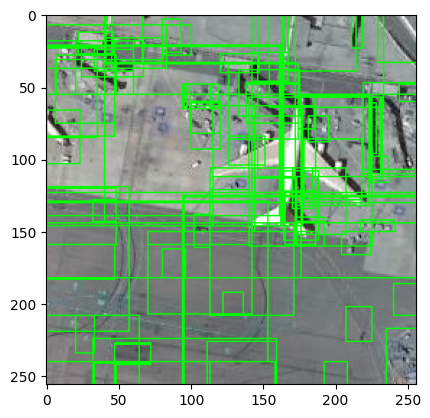

In [13]:
file_name = 'airplane_440'
img = cv2.imread(os.path.join('/content/Images/Images/', file_name + '.jpg'))
image_copy = img.copy()  # make a copy to draw on

# create selective search object and set image
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image_copy)
ss.switchToSelectiveSearchFast()  # quick mode (less accurate but faster)

rects = ss.process()  # list of region proposals (x, y, w, h)
print(f'Number of selected proposals: {rects.shape[0]}')

# draw the 100 proposals on image
for idx, rect in enumerate(rects[:100, :]):
    x1, y1, w, h = rect
    x2, y2 = x1 + w, y1 + h
    cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.imshow(image_copy)  # show image with drawn box


In [36]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 list_name,
                 batch_size=32,
                 dim=(224, 224),
                 n_channels=3,
                 n_classes=2,
                 shuffle=False,
                 image_path: str = './',
                 annotation_path: str = './'
                 ):

        self.list_name = list_name
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.image_path = image_path
        self.annotation_path = annotation_path

    def __len__(self):
        return int(np.floor(len(self.list_name) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.list_name[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = self.__data_generation(indexes)

        return X, y

    def __data_generation(self, indexes):
        X = np.zeros((self.batch_size * 100, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * 100), dtype=int)

        for i, idx in enumerate(indexes):
            image = cv2.imread(os.path.join(self.image_path, idx))
            df = pd.read_csv(os.path.join(self.annotation_path, idx.split('.')[0] + '.csv'))

            gtvalues = []
            for i, rows in df.iterrows():
                for _, row in rows.items():
                    x1 = int(row.split(' ')[0])
                    y1 = int(row.split(' ')[1])
                    x2 = int(row.split(' ')[2])
                    y2 = int(row.split(' ')[3])

                    gtvalues.append({'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2})

            ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            rects = ss.process()
            image_copy = image.copy()
            plane_cnt = 0
            background_cnt = 0

            for idx, rect in enumerate(rects[:100, :]):
                for gtvalue in gtvalues:
                    x1, y1, w, h = rect
                    x2, y2 = x1 + w, y1 + h
                    box2 = {'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2}

                    iou = iou_calc(box2, gtvalue)

                    current_index = i * 100 + plane_cnt + background_cnt
                    if current_index >= X.shape[0]:
                        break

                    if iou > 0.7:
                        croped_image = image[y1:y2, x1:x2]
                        resized_image = cv2.resize(croped_image, self.dim)
                        X[i * 100 + plane_cnt + background_cnt, ] = resized_image
                        y[i * 100 + plane_cnt + background_cnt] = 1
                        plane_cnt += 1

                    elif iou < 0.3:
                        croped_image = image[y1:y2, x1:x2]
                        resized_image = cv2.resize(croped_image, self.dim)
                        X[i * 100 + plane_cnt + background_cnt, ] = resized_image
                        y[i * 100 + plane_cnt + background_cnt] = 0
                        background_cnt += 1

                    if plane_cnt + background_cnt >= 100:
                        break

                if plane_cnt + background_cnt >= 100:
                    break

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)


In [46]:
# get names of image
list_names = os.listdir('/content/Images/Images')
# create train generator and validation generator
training_generator = DataGenerator(list_name = list_names[:20], batch_size = 1, image_path= '/content/Images/Images', annotation_path = '/content/Airplanes_Annotations')
validation_generator = DataGenerator(list_name = list_names[20:40], batch_size = 1, image_path= '/content/Images/Images', annotation_path = '/content/Airplanes_Annotations')

In [47]:
X, Y = validation_generator.__getitem__(19)

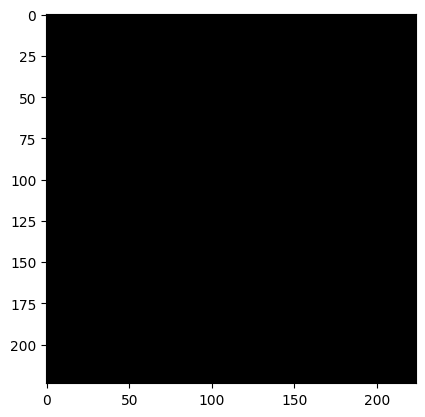

In [48]:
plt.imshow(X[1].astype(int))

In [49]:
Y[1]

array([1., 0.])